In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import statistics
import sklearn as sk
import os
import glob
import math
import collections
import pylab
import warnings
import tensorflow as tf
keras = tf.keras
import keras.backend as K
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score as accuracy
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from keras.callbacks import Callback
from pandas import DataFrame
from pprint import pprint

from keras.callbacks import EarlyStopping
from keras.layers import Dropout, Embedding, LSTM, Bidirectional
from tensorflow.keras.layers import Input, concatenate, Dense
from tensorflow.keras.models import Model
from tensorflow.python.keras.utils.vis_utils import plot_model
from keras import models, layers
from keras.optimizers import Adam, RMSprop
from keras.layers import Activation, Dense
from keras.models import Sequential
from keras.preprocessing import sequence
from keras import metrics
from sklearn.metrics import f1_score

import scipy.stats as stats

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
warnings.simplefilter('ignore')

In [2]:
def divide_genre(path):
    file = glob.glob(path)
    file_up_down          = [file_name for file_name in file if "up-down" in file_name]
    file_up_down_big      = [file_name for file_name in file_up_down if "big" in file_name]
    file_up_down_small    = [file_name for file_name in file_up_down if "small" in file_name]
    
    file_left_right       = [file_name for file_name in file if "left-right" in file_name]
    file_left_right_big   = [file_name for file_name in file_left_right if "big" in file_name]
    file_left_right_small = [file_name for file_name in file_left_right if "small" in file_name]
    
    return list([file_up_down_big, file_up_down_small, file_left_right_big, file_left_right_small])

In [3]:
def separate_train_test(files):
    
    def random_choise(files):
        random.seed(0)
        test_file = random.choice(files) # 入力されたファイル群から１つをTestファイルとして抽出
        files.remove(test_file) # 抽出したファイルを元のファイル群から削除
        train_file = files # 削除後のファイル群をTrainファイルとする
        return train_file, test_file

    train_list = []
    test_list = []
    for label_num in range(len(files)):
        train, test = random_choise(files[label_num])
        train_list.extend(train)
        test_list.append(test)
    return train_list, test_list

In [4]:
list_osawa_file  = divide_genre("data/*osawa*")
list_sasaki_file = divide_genre("data/*sasaki*")

In [5]:
train_osawa, test_osawa = separate_train_test(list_osawa_file)
train_sasaki, test_sasaki = separate_train_test(list_sasaki_file)

In [6]:
train = train_osawa + train_sasaki

In [7]:
test = test_osawa + test_sasaki

In [8]:
def minmax(value, max_, min_):
    return (value - min_)/(max_ - min_)

In [9]:
def prepro_just(file, window_size):
    def append_data(data_a, data_b):
        for i in range(len(data_b)):
            data_a.append(data_b[i])

        return data_a
    
    data_acc_fin = []
    data_do_fin = []
    data_rot_fin = []
    data_acc_z_fin = []
    label_fin = []
    
    for file_num in range(len(file)):
        df = pd.read_csv(file[file_num])
        if '姿勢なし' in df.values:
            continue
        
        # 0:left-right+small
        # 1:left-right+big
        # 2:up-down+small
        # 3:up-down+big
        df = df.replace({'直立':0, '歩行':1, '着席':3, '寝る':2})
        df = df[['date', 'label', 's_movement', 'do_alpha', 'do_beta', 'do_gamma', 
                 'acc_g_x', 'acc_g_y', 'acc_g_z', 'acc_x', 'acc_y', 'acc_z', 'rot_alpha', 'rot_beta', 'rot_gamma']]
        
        # acceleration composite
        df['acc_composite'] = (df['acc_x']**2 + df['acc_y']**2 + df['acc_z']**2) ** 1/2
        df['acc_composite_minmax'] = minmax(df['acc_composite'], 1262.865, 0)
        
        # rotation pre
        df['do_beta_pre'] = (df['do_beta']+180)/360
        df['do_gamma_pre'] = (df['do_gamma']+90)/180
        
        df['rot_beta_pre'] = (df['rot_beta']+300)/600
        df['rot_gamma_pre'] = (df['rot_gamma']+300)/600
        
        # standardization
        df['acc_z_sta_min'] = df['acc_z'] + 18
#         df['acc_z_sta_max'] = df['acc_z'] + 26
        
        df['acc_z_sta_min_minmax'] = minmax(df['acc_z_sta_min'], 54.800000, 2.2)
#         df['acc_z_sta_max_minmax'] = minmax(df['acc_z_sta_max'], 51, 7)
        
#         if mima=='min':
        data_acc = np.array(df[['acc_composite_minmax']])
        data_do = np.array(df[['do_beta_pre', 'do_gamma_pre']])
        data_rot = np.array(df[['rot_beta_pre', 'rot_gamma_pre']])
        data_acc_z = np.array(df[['acc_z_sta_min_minmax']])
#         elif mima=='max':
#             data_acc = np.array(df[['acc_composite_minmax']])
#             data_do = np.array(df[['do_beta_pre', 'do_gamma_pre']])
#             data_rot = np.array(df[['rot_beta_pre', 'rot_gamma_pre']])
#             data_acc_z = np.array(df[['acc_z_sta_max_minmax']])
        label = np.array(df[['label']])
        
        data_acc = [data_acc[i:i+window_size] for i in range(len(data_acc)-window_size)]
        data_do = [data_do[i:i+window_size] for i in range(len(data_do)-window_size)]
        data_rot = [data_rot[i:i+window_size] for i in range(len(data_rot)-window_size)]
        data_acc_z = [data_acc_z[i:i+window_size] for i in range(len(data_acc_z)-window_size)]
        
        data_label = [label[i+window_size] for i in range(len(label)-window_size)]
        
        data_acc = append_data(data_acc_fin, data_acc)
        data_do = append_data(data_do_fin, data_do)
        data_rot = append_data(data_rot_fin, data_rot)
        data_acc_z = append_data(data_acc_z_fin, data_acc_z)
        data_label = append_data(label_fin, data_label)
    
    data_acc_fin = np.array(data_acc)
    data_do_fin = np.array(data_do)
    data_rot_fin = np.array(data_rot)
    data_acc_z_fin = np.array(data_acc_z)
    
    label_fin = np.array(data_label, dtype='int32')
    
    return data_acc_fin, data_do_fin, data_rot_fin, data_acc_z_fin, label_fin

In [10]:
window_size = 10

train_acc, train_do, train_rot, train_acc_z, train_label = prepro_just(train, window_size)
test_acc, test_do, test_rot, test_acc_z, test_label = prepro_just(test, window_size)

In [11]:
print(train_acc.shape, train_do.shape, train_rot.shape, train_acc_z.shape, train_label.shape)
print(test_acc.shape, test_do.shape, test_rot.shape, test_acc_z.shape, test_label.shape)

(22687, 10, 1) (22687, 10, 2) (22687, 10, 2) (22687, 10, 1) (22687, 1)
(2406, 10, 1) (2406, 10, 2) (2406, 10, 2) (2406, 10, 1) (2406, 1)


In [12]:
type(test_acc)

numpy.ndarray

In [13]:
np.unique(train_label)

array([0, 1, 2, 3], dtype=int32)

In [11]:
class_num = 4
n_hidden = 100

In [12]:
# 入力を定義
input_acc = Input(shape=(window_size,1))
input_do = Input(shape=(window_size,2))
input_rot = Input(shape=(window_size,2))
input_acc_z = Input(shape=(window_size,1))

# 入力1から結合前まで(Conv1D)
acc = tf.keras.layers.Conv1D(filters=64, kernel_size=3, dilation_rate=1, activation='relu')(input_acc)
acc = tf.keras.layers.Conv1D(filters=64, kernel_size=3, dilation_rate=2, activation='relu')(acc)

acc = Model(inputs=input_acc, outputs=acc)

# 入力2から結合前まで(Conv1D)
do = tf.keras.layers.Conv1D(filters=64, kernel_size=3, dilation_rate=1, activation='relu')(input_do)
do = tf.keras.layers.Conv1D(filters=64, kernel_size=3, dilation_rate=2, activation='relu')(do)

do = Model(inputs=input_do, outputs=do)

# 入力1から結合前まで(Conv1D)
rot = tf.keras.layers.Conv1D(filters=64, kernel_size=3, dilation_rate=1, activation='relu')(input_rot)
rot = tf.keras.layers.Conv1D(filters=64, kernel_size=3, dilation_rate=2, activation='relu')(rot)

rot = Model(inputs=input_rot, outputs=rot)

# 入力2から結合前まで(Conv1D)
acc_z = tf.keras.layers.Conv1D(filters=64, kernel_size=3, dilation_rate=1, activation='relu')(input_acc_z)
acc_z = tf.keras.layers.Conv1D(filters=64, kernel_size=3, dilation_rate=2, activation='relu')(acc_z)

acc_z = Model(inputs=input_acc_z, outputs=acc_z)

# 結合
combined = concatenate([acc.output, do.output, rot.output, acc_z.output])

# 密結合
z = tf.keras.layers.LSTM(units=n_hidden, return_sequences=True)(combined)
z = tf.keras.layers.LSTM(units=n_hidden, return_sequences=False)(z)

z = tf.keras.layers.Dense(units=10, activation='relu')(z)
z = tf.keras.layers.Dense(class_num, activation='softmax')(z)

# モデル定義とコンパイル
rnn = tf.keras.Model(inputs=[acc.input, do.input, rot.input, acc_z.input], outputs=z)
rnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
rnn.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 1)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10, 2)]      0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 10, 2)]      0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 10, 1)]      0                                            
____________________________________________________________________________________________

In [16]:
l = rnn.layers[7]
l.get_weights()

[array([[[-0.1259863 ,  0.03570956,  0.10315929,  0.13356434,
          -0.16238649, -0.08190893, -0.13347416, -0.09564651,
          -0.15756086, -0.02953774, -0.0266073 ,  0.06849574,
           0.10208984, -0.07330423, -0.02315633,  0.15494446,
          -0.10100771,  0.08858036, -0.1130496 , -0.1647074 ,
           0.167578  ,  0.05835639,  0.0743992 ,  0.03481634,
          -0.01221302,  0.00984579,  0.15628503, -0.01234429,
          -0.16892414,  0.06961612,  0.11595835, -0.10542133,
          -0.15783164, -0.13850072, -0.04264359, -0.04031448,
           0.02133715, -0.08567951,  0.01320167,  0.17480423,
           0.09703298,  0.07699178, -0.15771957, -0.12168053,
           0.02956818,  0.01169552,  0.13351877, -0.12017915,
          -0.1519843 ,  0.08549441,  0.14568801, -0.06894267,
           0.09646107,  0.08272241, -0.10169288,  0.13759924,
           0.12580772, -0.06955958,  0.11084004,  0.04147778,
          -0.09692352,  0.00274318, -0.13820311, -0.13127059]],
 
    

In [13]:
rnn.compile(loss='sparse_categorical_crossentropy', 
                      optimizer='adam', 
                      metrics=['accuracy'])

In [14]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
rnn.fit([train_acc, train_do, train_rot, train_acc_z], train_label,
        batch_size=64,
        epochs=10000,
        validation_split=0.1,
        callbacks=[callback]
       )

predict_classes = rnn.predict([test_acc, test_do, test_rot, test_acc_z])
true_classes = test_label

pre_cla = []

for i in range(len(predict_classes)):
    max_ = np.amax(predict_classes[i])
    for j in range(len(predict_classes[i])):
        if max_==predict_classes[i][j]:
            pre_cla.append(j)

predict_classes = np.array(pre_cla)

Epoch 1/10000
320/320 [==============================] - 7s 12ms/step - loss: 0.7847 - accuracy: 0.6104 - val_loss: 0.4106 - val_accuracy: 0.8641
Epoch 2/10000
320/320 [==============================] - 3s 9ms/step - loss: 0.0797 - accuracy: 0.9728 - val_loss: 1.3764 - val_accuracy: 0.4886
Epoch 3/10000
320/320 [==============================] - 2s 7ms/step - loss: 0.0303 - accuracy: 0.9897 - val_loss: 0.6867 - val_accuracy: 0.7441
Epoch 4/10000
320/320 [==============================] - 2s 7ms/step - loss: 0.0192 - accuracy: 0.9932 - val_loss: 1.0579 - val_accuracy: 0.6407


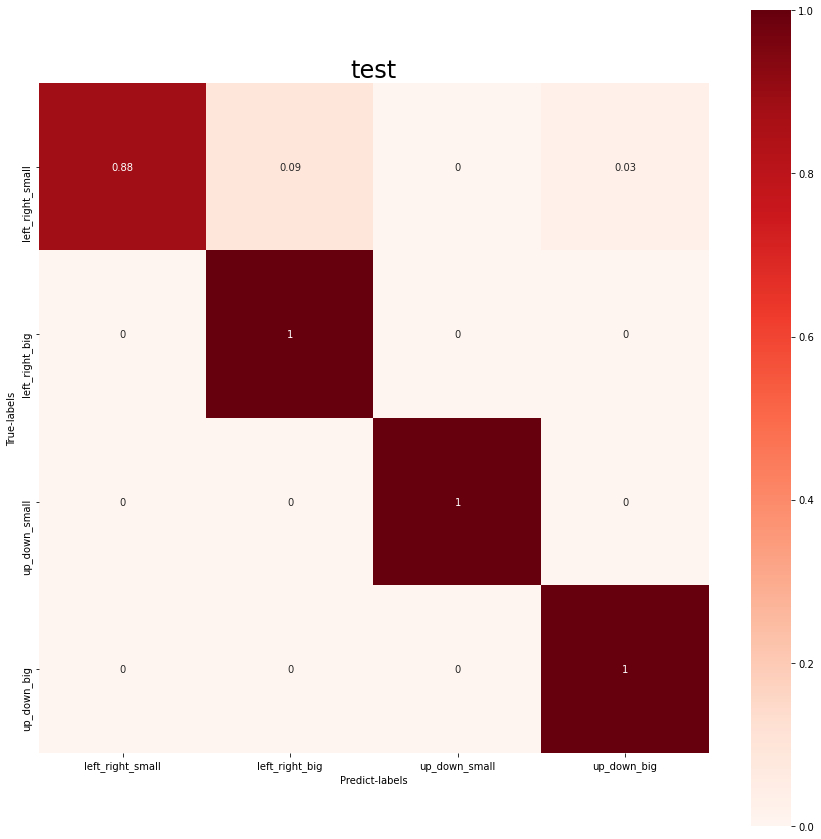

In [16]:
target_names = ['left_right_small', 'left_right_big', 'up_down_small', 'up_down_big']
title = 'test'

def print_cmx(y_true, y_pred, labels, title):
    cmx_data = confusion_matrix(y_true, y_pred)
    
    cmx_data = cmx_data.astype('float') / cmx_data.sum(axis=1)[:, np.newaxis]
    
    cmx_data = cmx_data.round(2)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    plt.figure(figsize = (15,15))
    sn.heatmap(df_cmx, annot=True, fmt='g', square = True, cmap='Reds', vmin=0.0, vmax=1.0)
    sn.set_context('poster')
    
    plt.ylim(4, 0)
    plt.xlabel("Predict-labels")
    plt.ylabel("True-labels")
    
    plt.title(title)
#     plt.savefig('../../../../data_image/confusion_matrix/200708/'+title+'.png')    
    plt.show()    
    return 
    
print_cmx(true_classes, predict_classes, target_names, title)

In [12]:
l = rnn.layers[7]
l.get_weights()

[array([[[ 0.09260963,  0.08079112, -0.15501861,  0.05991646,
          -0.09732731, -0.02816252,  0.4701737 , -0.12720065,
           0.23571402, -0.05862036,  0.02933812, -0.12998405,
           0.20174989, -0.17472205, -0.17181791,  0.06706315,
          -0.05058275,  0.04446934,  0.1110663 , -0.12609926,
          -0.48334706, -0.13894105,  0.48290014,  0.11177219,
           0.00961643,  0.4635312 , -0.05604097, -0.38083616,
          -0.21138968,  0.01416725,  0.03964747,  0.24123323,
          -0.11784689,  0.00942253, -0.20342556,  0.46958247,
           0.55074984,  0.3956203 ,  0.05232222,  0.22194132,
          -0.51804996, -0.30994937, -0.08266456, -0.03688082,
           0.581103  ,  0.22002569, -0.26059437,  0.33626592,
           0.09262782, -0.17575549, -0.01658361, -0.12992796,
          -0.14914367, -0.02036634,  0.39558858,  0.02487605,
          -0.07317794, -0.20648386,  0.04502194,  0.06875788,
          -0.01020426, -0.37162325,  0.3856057 ,  0.2853082 ]],
 
    

In [15]:
l_1 = rnn.layers[7]
l_1.get_weights()

[array([[[ 0.09260963,  0.0746787 , -0.15501861,  0.07355212,
          -0.09732731, -0.02816252,  0.53642476, -0.12720065,
           0.25437   , -0.07668994,  0.02933812, -0.12998405,
           0.21339598, -0.17472205, -0.17181791,  0.06706315,
          -0.05058275,  0.04446934,  0.1110663 , -0.12609926,
          -0.5462891 , -0.13894105,  0.54855746,  0.14253621,
           0.0097314 ,  0.51294243, -0.06310222, -0.44204247,
          -0.21138968,  0.01416725,  0.03964747,  0.2499216 ,
          -0.11784689,  0.00942253, -0.18305327,  0.5387885 ,
           0.6273895 ,  0.45669463,  0.05232222,  0.23943147,
          -0.58388275, -0.34913257, -0.08266456, -0.03688082,
           0.6624751 ,  0.2442679 , -0.30788183,  0.36181802,
           0.11159351, -0.17575549, -0.01658361, -0.12992796,
          -0.14914367, -0.02036634,  0.4390408 ,  0.02487605,
          -0.07317794, -0.20648386,  0.04502194,  0.06875788,
          -0.00713551, -0.4094869 ,  0.41256362,  0.31054837]],
 
    

<function matplotlib.pyplot.show(*args, **kw)>

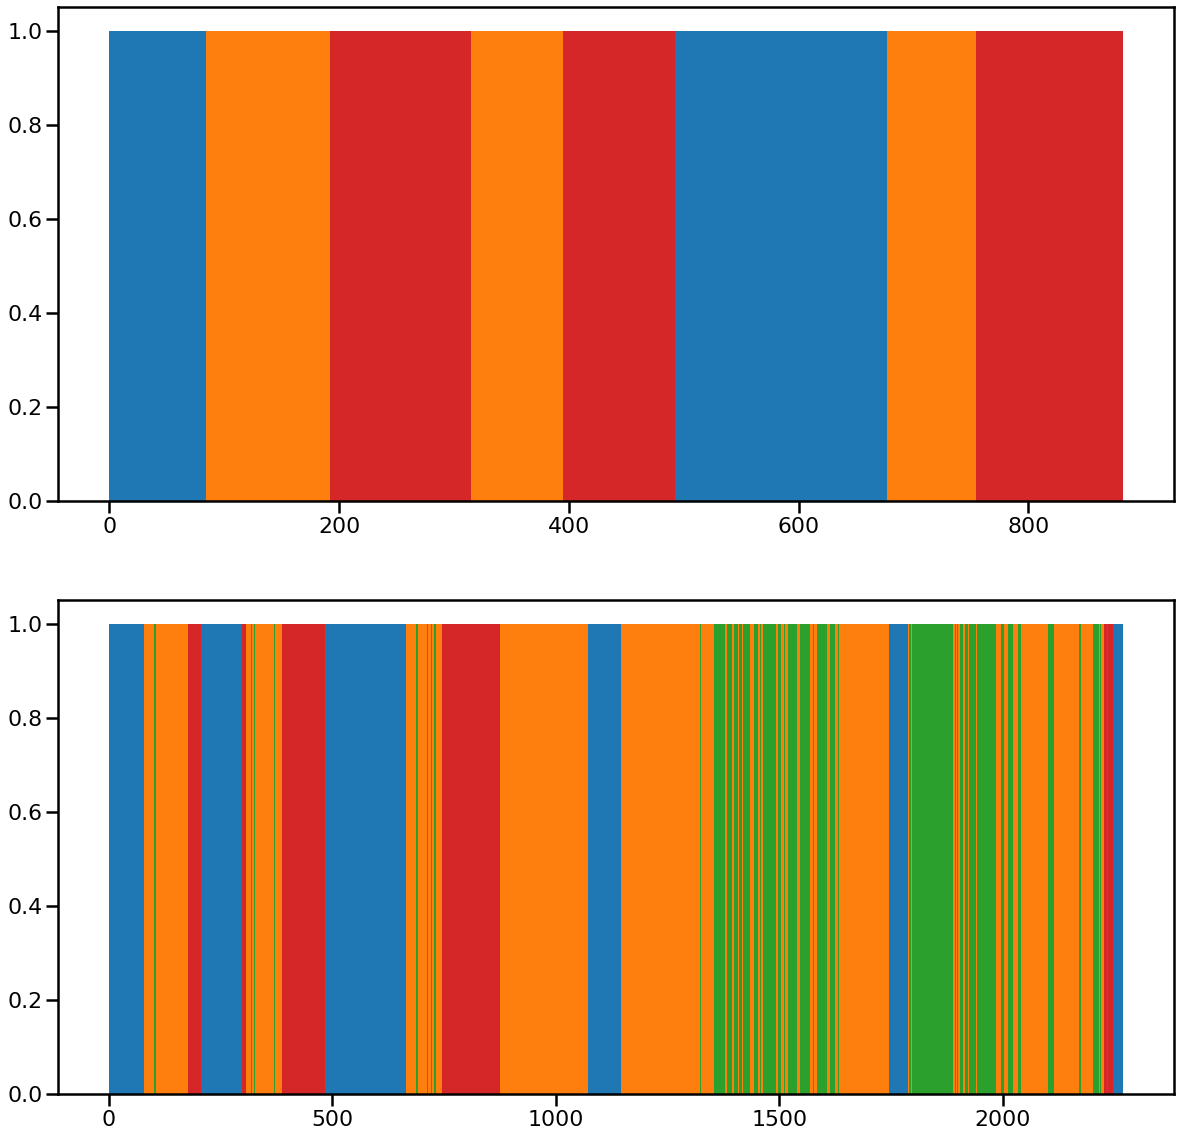

In [13]:
files = glob.glob('../../data/building_home/0all/test/*.csv')

df_change = pd.read_csv(files[0])
pre = pd.DataFrame({'label':predict_classes})
df_change = df_change.replace({'直立':0, '歩行':1, '階段 - 下り':2, '階段 - 上り':2, '着席':0, '寝る':3})


sliced_label_0 = np.identity(4)[df_change.label]
sliced_label_1 = np.identity(4)[pre.label]

bar_0 = np.argmax(sliced_label_0,axis=1)
bar_1 = np.argmax(sliced_label_1,axis=1)

plt.figure(figsize=(20, 20))
plt.subplot(2,1,1)
for t in range(4):
    plt.bar(range(len(bar_0)),df_change.label==t,width=1)
    
plt.subplot(2,1,2)
for t in range(4):
    plt.bar(range(len(bar_1)),pre.label==t,width=1)
    
# plt.savefig('../../../../data_image/confusion_matrix/200708/'+title+'_time.png') 
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

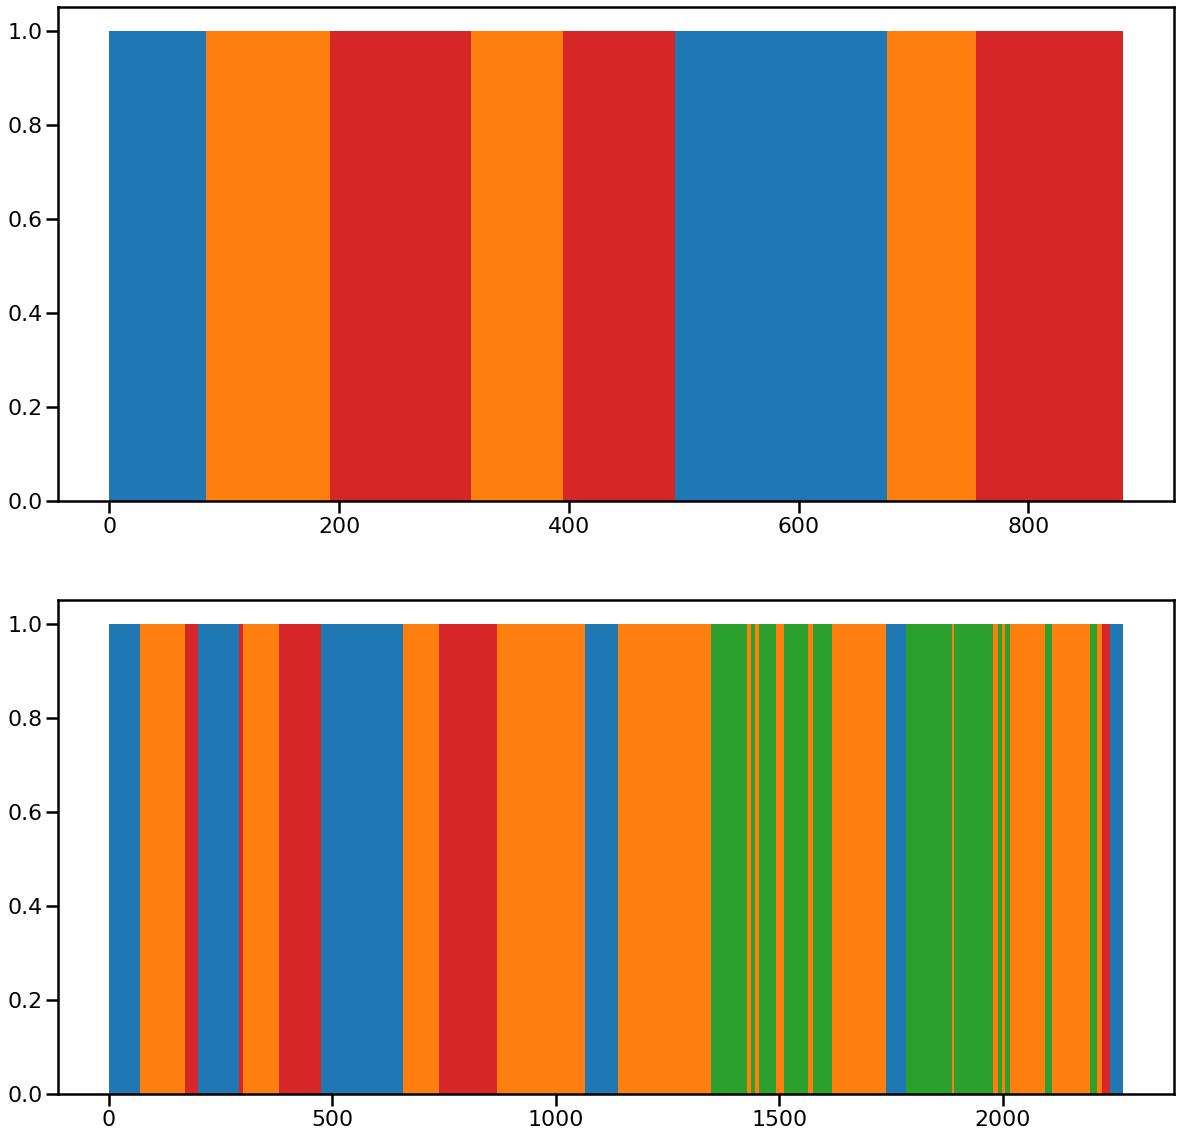

In [14]:
pc = predict_classes
label_size = 15

labe_fin = []

for l in range(len(pc)-label_size):
    num_true = l + label_size
    labe_fin.append(stats.mode(pc[l:num_true])[0][0])

for l_ in range(label_size):
    labe_fin.append(labe_fin[-1:][0])

labe_fin = np.array(labe_fin)

files = glob.glob('../../data/building_home/0all/test/*.csv')

df_change = pd.read_csv(files[0])
pre = pd.DataFrame({'label':labe_fin})
df_change = df_change.replace({'直立':0, '歩行':1, '階段 - 下り':2, '階段 - 上り':2, '着席':0, '寝る':3})


sliced_label_0 = np.identity(4)[df_change.label]
sliced_label_1 = np.identity(4)[pre.label]

bar_0 = np.argmax(sliced_label_0,axis=1)
bar_1 = np.argmax(sliced_label_1,axis=1)

plt.figure(figsize=(20, 20))
plt.subplot(2,1,1)
for t in range(4):
    plt.bar(range(len(bar_0)),df_change.label==t,width=1)
    
plt.subplot(2,1,2)
for t in range(4):
    plt.bar(range(len(bar_1)),pre.label==t,width=1)
    
title = 'divide_comp_4er_nomal_inomata_clean'
    
# plt.savefig('../../../../data_image/confusion_matrix/200708/'+title+'_time.png') 
plt.show

In [ ]:
!! pip3 install tensorflowjs

In [15]:
import tensorflowjs as tfjs

In [17]:
rnn.save('model_max.h5')

In [18]:
!!tensorflowjs_converter --input_format keras model_max.h5 ../model

[]